# Bite Size Bayes

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

[In the previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/08_soccer.ipynb) I introduced the World Cup problem:

>In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:
>
>1. How confident should we be that France is the better team?
>
>2. If the same teams played again, what is the chance Croatia would win?

I started with the assumption that for any team against any other team there is some unknown goal-scoring rate, λ.

And I showed that if we know λ, we can compute the probability of scoring $k$ goals in a game:

$f(k; λ) = λ^k \exp(-λ) ~/~ k!$

This function is the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), and we can use SciPy to compute it.

For example, if we know that λ is 1.4, we can compute the distribution of $k$ like this:


In [2]:
from scipy.stats import poisson

λ = 1.4
xs = np.arange(11)
ys = poisson.pmf(xs, λ)
pmf_goals = pd.Series(ys, index=xs)

pmf_goals

0     0.246597
1     0.345236
2     0.241665
3     0.112777
4     0.039472
5     0.011052
6     0.002579
7     0.000516
8     0.000090
9     0.000014
10    0.000002
dtype: float64

In theory, the values of $k$ go to infinity, but I cut it off at 10 because higher values have very low probability.

Here's what the distribution of $k$ looks like:

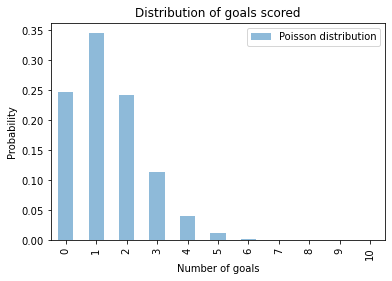

In [3]:
pmf_goals.plot.bar(color='C0', alpha=0.5, label='Poisson distribution')

plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Distribution of goals scored')
plt.legend();

Because the values of $k$ are discrete integers, I use a bar chart to plot the distribution.

Next I used a gamma distributon to represent the prior distribution of λ.  I set the parameter of the gamma distribution, α, to 1.4, which is the average number of goals each team scores in World Cup play.

I broke the range of values for λ into 101 discrete possibilities and used SciPy to compute the prior probabilities:

In [4]:
from scipy.stats import gamma

α = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma.pdf(qs, α)

prior = pd.Series(ps, index=qs)
prior /= prior.sum()

Here's what the prior distribution looks like:

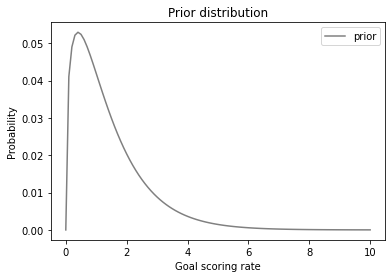

In [5]:
prior.plot(label='prior', color='gray')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Prior distribution')
plt.legend();

Because the values of $λ$ are continuous, I use a line to plot the distribution.

Next we did a Bayesian update, using the Poisson distribution to compute the likelihood of the data, $k$, for each possible goal scoring rate, $λ$

$ f(k; λ) = λ^k \exp(-λ) ~/~ k! $

Since France scored 4 goals, the likelihood of the data is:

In [6]:
λs = prior.index
k = 4
likelihood = poisson.pmf(k, λs)

And we can use the following function to do the update:

In [7]:
def bayes_update(pmf, likelihood):
    """Do a Bayesian update.
    
    pmf: Series that represents the prior
    likelihood: sequence of likelihoods
    
    returns: float probability of the data
    """
    pmf *= likelihood
    prob_data = pmf.sum()
    pmf /= prob_data
    return prob_data

In [8]:
france = prior.copy()
bayes_update(france, likelihood)

0.05015532557804499

And we can do the same thing for Croatia, given that they scored 2 goals:

In [9]:
k = 2
λs = prior.index
likelihood = poisson.pmf(k, λs)

croatia = prior.copy()
bayes_update(croatia, likelihood)

0.1609321178598705

Here's what the results look like.

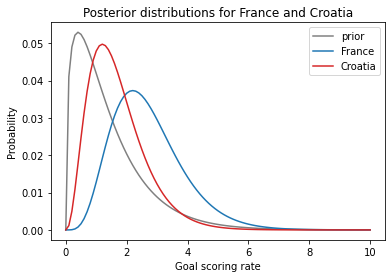

In [10]:
prior.plot(label='prior', color='gray')
france.plot(label='France', color='C0')
croatia.plot(label='Croatia', color='C3')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Posterior distributions for France and Croatia')
plt.legend();

In the previous notebook we used the following function to compute the mean of a PMF.

In [11]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

We can use it to compute the posterior means for France and Croatia.

In [12]:
pmf_mean(france), pmf_mean(croatia)

(2.699772393342308, 1.6999765866755225)

Based on the outcome of the game, we have some reason to think France is the better team.

But if we look at the posterior distribution of λ for France and Croatia, there is still a lot of overlap, which means we are still not certain which is the better team.

In the next section, we'll use the posterior distributions to compute the "probability of superiority".

### Probability of superiority

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, "better" means having a higher goal-scoring rate against the opponent.  We can use the posterior distributions to compute the probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's.

The following function takes a Series that represents a PMF and draws a sample from it.

In [13]:
def pmf_choice(pmf, n):
    """Draw a random sample from a PMF.
    
    pmf: Series representing a PMF
    n: number of values to draw
    
    returns: NumPy array
    """
    return np.random.choice(pmf.index,
                            size=n, 
                            replace=True, 
                            p=pmf)

`pmf_choice` uses `np.random.choice`, which chooses `n` values from the PMF with replacement, so the same value can appear more than once.  It uses the probabilities from the PMF as weights, so the number of times each value appears is proportional to its probability.

Here's a sample from the posterior distribution for France.

In [14]:
sample_france = pmf_choice(france, 1000)
sample_france.mean()

2.6954000000000002

And here's a sample for Croatia.

In [15]:
sample_croatia = pmf_choice(croatia, 1000)
sample_croatia.mean()

1.7061000000000002

To estimate the probability of superiority, we can count the number of times the value from France's distribution exceeds the value from Croatia's distribution.

In [16]:
np.mean(sample_france > sample_croatia)

0.755

On the basis of one game, we have moderate confidence that France is actually the better team.

### Predicting the rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?

To answer this question, we'll generate a sample from the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, λ, the distribution of goals would be a Poisson distributon with parameter λ.

Since we don't know λ, we can use the sample we generated in the previous section to generate a sample of goals, like this:

In [17]:
goals_france = np.random.poisson(sample_france)

`np.random.poisson` uses each element of `sample_france` to generate a random value; that is, each value in the result is based on a different value of λ.

To see what the resulting distribution looks like, we'll use this function from a previous notebook:

In [18]:
def pmf_from_seq(seq):
    """Make a PMF from a sequence of values.
    
    seq: sequence
    
    returns: Series representing a PMF
    """
    pmf = pd.Series(seq).value_counts(sort=False).sort_index()
    pmf /= pmf.sum()
    return pmf

2.727

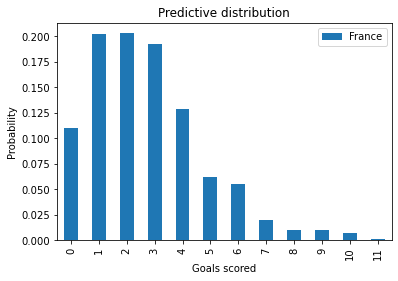

In [19]:
pmf_france = pmf_from_seq(goals_france)
pmf_france.plot.bar(color='C0', label='France')

plt.xlabel('Goals scored')
plt.ylabel('Probability')
plt.title('Predictive distribution')
plt.legend()

goals_france.mean()

This distribution represents two sources of uncertainty: we don't know the actual value of λ, and even if we did, we would not know the number of goals in the next game.

**Exercise:** Generate and plot the predictive distribution for Croatia.

1.72

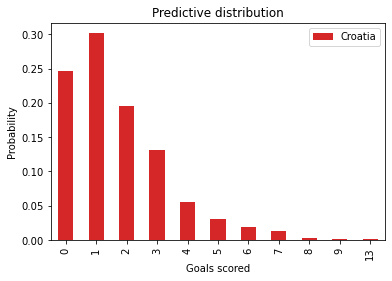

In [20]:
# Solution

goals_croatia = np.random.poisson(sample_croatia)

pmf_croatia = pmf_from_seq(goals_croatia)
pmf_croatia.plot.bar(label='Croatia', color='C3')

plt.xlabel('Goals scored')
plt.ylabel('Probability')
plt.title('Predictive distribution')
plt.legend()

goals_croatia.mean()

In a sense, these distributions represent the outcomes of 1000 simulated games.

**Exercise:** Compute the fraction of simulated rematches Croatia would win, how many France would win, and how many would end in a tie.

In [21]:
# Solution

np.mean(goals_croatia > goals_france)

0.27

In [22]:
# Solution

np.mean(goals_france > goals_croatia)

0.585

In [23]:
# Solution

np.mean(goals_france == goals_croatia)

0.145

Assuming that Croatia wins half of the ties, their chance of winning the rematch is about 33%.

## Summary

In this notebook, we finished off the World Cup problem:

* We used posterior distributions to generate samples of goal-scoring rates.

* We compared samples to compute a "probability of superiority".

* We used samples and `np.random.poisson` to generate samples of goals score and to estimate their distributions.

* We used those distributions to compute the probabilities of winning, losing, and tying in a rematch.

The goal distributions we computed are called "[posterior predictive distributions](https://en.wikipedia.org/wiki/Posterior_predictive_distribution)" because they use posterior distribution to make predictions.

[In the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/10_joint.ipynb) we'll take a break from Bayesian methods and learn about an important idea in probability: joint distributions.

But first, here's an exercise where you can practice what you learned in this notebook.

## Exercise

**Exercise:** Here's a variation on the World Cup Problem:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

In this version, notice that the data is not the number of goals in a fixed period of time, but the time between goals.

To compute the likelihood of data like this, we can take advantage of the theory of [Poisson processes](https://en.wikipedia.org/wiki/Poisson_point_process).  In our model of a soccer game, we assume that each team has a goal-scoring rate, λ, in goals per game.  And we assume that λ is constant, so the chance of scoring a goal in the same at any moment of the game.

Under these assumptions, the distribution of goals follows a Poisson distribution, as we've already seen.  Also, the time between goals follows an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

If the goal-scoring rate is λ, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

$f(t; λ) = λ~\exp(-λ t)$

Because $t$ is a continuous quantity, the value of this expression is not really a probability; technically it is a [probability density](https://en.wikipedia.org/wiki/Probability_density_function).  However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

To see what the exponential distribution looks like, let's assume again that λ is 1.4; we can compute the distribution of $t$ like this:

In [24]:
def expo_pdf(t, λ):
    """Compute the PDF of the exponential distribution.
    
    t: time
    λ: rate
    
    returns: probability density
    """
    return λ * np.exp(-λ * t)

In [25]:
λ = 1.4
ts = np.linspace(0, 4, 101)
ys = expo_pdf(ts, λ)
pmf_time = pd.Series(ys, index=ts)
pmf_time /= pmf_time.sum()

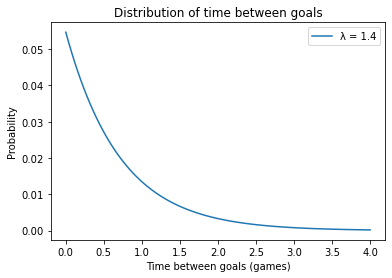

In [26]:
pmf_time.plot(label='λ = 1.4')

plt.xlabel('Time between goals (games)')
plt.ylabel('Probability')
plt.title('Distribution of time between goals')
plt.legend();

It is counterintuitive, but true, that the most likely time to score a goal is immediately.  After that, the probability of each possible interval is a little lower.

With a goal-scoring rate of 1.4, it is possible that a team will take more than one game to score a goal, but it is unlikely that they will take more than two games.

Now we're ready to solve the problem.  Here are the steps I recommend:

1. Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of λ.  Don't forget to convert all times into units of games.

2. Use `bayes_update` to compute the posterior distribution of λ for Germany after the first goal.  If the total probability of the data is greater than 1, don't panic; because the likelihoods are not probabilities, the return value from `bayes_update` is not a probability either.  But the posterior distribution is still valid.

3. Compute the likelihood of scoring another goal after 12 more minutes and do another update.  Plot the prior, posterior after one goal, and posterior after two goals.

4. Use `pmf_choice` to generate a sample of 1000 values from the posterior distribution of goal scoring rate.

5. Use `np.random.poisson` to compute a sample of goals Germany might score during the remaining time in the game, `90-23` minutes.  Note: you will have to think about how to generate predicted goals for a fraction of a game.

6. Compute and plot the PMF of possible goals scored and select from it the probability of scoring 5 more goals.  

In [27]:
# Solution

germany = prior.copy()
λs = germany.index

In [28]:
# Solution

t = 11/90
likelihood = expo_pdf(t, λs)

In [29]:
# Solution

bayes_update(germany, likelihood)

1.0728988807549489

In [30]:
# Solution

t = 12/90
likelihood = expo_pdf(t, λs)

In [31]:
# Solution

germany2 = germany.copy()
bayes_update(germany2, likelihood)

1.4598709349606904

In [32]:
# Solution

pmf_mean(germany), pmf_mean(germany2)

(2.1358882653086892, 2.703059034926364)

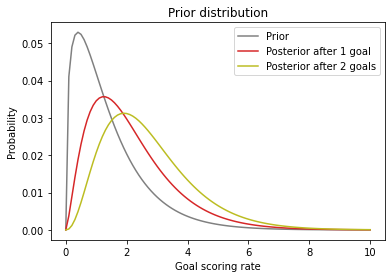

In [33]:
# Solution

prior.plot(color='gray', label='Prior')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C8', label='Posterior after 2 goals')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Prior distribution')
plt.legend();

In [34]:
# Solution

sample_germany = pmf_choice(germany2, 1000)
sample_germany.mean()

2.6945

In [35]:
# Solution

remaining_time = (90-23) / 90
goals_germany = np.random.poisson(sample_germany * remaining_time)

2.034

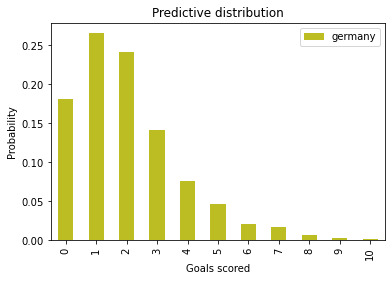

In [36]:
# Solution

pmf_germany = pmf_from_seq(goals_germany)
pmf_germany.plot.bar(color='C8', label='germany')

plt.xlabel('Goals scored')
plt.ylabel('Probability')
plt.title('Predictive distribution')
plt.legend()

goals_germany.mean()

In [37]:
# Solution

pmf_germany[5]

0.046